In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load data
df = pd.read_csv("online_retail_II.csv", encoding="ISO-8859-1")

# Basic cleaning
df = df.dropna(subset=["Customer ID"])
df["Invoice"] = df["Invoice"].astype(str)
df = df[~df["Invoice"].str.startswith("C")]
df = df[(df["Quantity"] > 0) & (df["Price"] > 0)]

# Fix datetime
df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"], dayfirst=True, errors="coerce")
df = df.dropna(subset=["InvoiceDate"])

# Create total price
df["TotalPrice"] = df["Quantity"] * df["Price"]

df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,TotalPrice
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,83.4
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,100.8
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,30.0


In [35]:
snapshot_date = df["InvoiceDate"].max() + pd.Timedelta(days=1)

rfm = df.groupby("Customer ID").agg({
    "InvoiceDate": lambda x: (snapshot_date - x.max()).days,
    "Invoice": "count",
    "TotalPrice": "sum"
})

rfm.columns = ["Recency", "Frequency", "Monetary"]
rfm.head()

,Recency,Frequency,Monetary
Customer ID,,,
12346.0,321,34,77556.46
12347.0,35,242,5408.50
12348.0,71,51,2019.40
12349.0,14,175,4428.69
12350.0,305,17,334.40


In [36]:
rfm["R_Score"] = pd.qcut(rfm["Recency"], 4, labels=[4,3,2,1])
rfm["F_Score"] = pd.qcut(rfm["Frequency"], 4, labels=[1,2,3,4])
rfm["M_Score"] = pd.qcut(rfm["Monetary"], 4, labels=[1,2,3,4])

# Convert to int
rfm["R_Score"] = rfm["R_Score"].astype(int)
rfm["F_Score"] = rfm["F_Score"].astype(int)
rfm["M_Score"] = rfm["M_Score"].astype(int)

rfm.head()

,Recency,Frequency,Monetary,R_Score,F_Score,M_Score
Customer ID,,,,,,
12346.0,321,34,77556.46,2,2,4
12347.0,35,242,5408.50,3,4,4
12348.0,71,51,2019.40,3,2,3
12349.0,14,175,4428.69,4,4,4
12350.0,305,17,334.40,2,1,1


In [37]:
rfm["RFM_Total"] = rfm["R_Score"] + rfm["F_Score"] + rfm["M_Score"]

def segment_customer(row):
    score = row["RFM_Total"]
    if score >= 10:
        return "Champions"
    elif score >= 8:
        return "Loyal"
    elif score >= 5:
        return "At Risk"
    else:
        return "Others"

rfm["Segment"] = rfm.apply(segment_customer, axis=1)

rfm["Segment"].value_counts()

,count
Segment,
At Risk,1877
Champions,1719
Loyal,1155
Others,1109


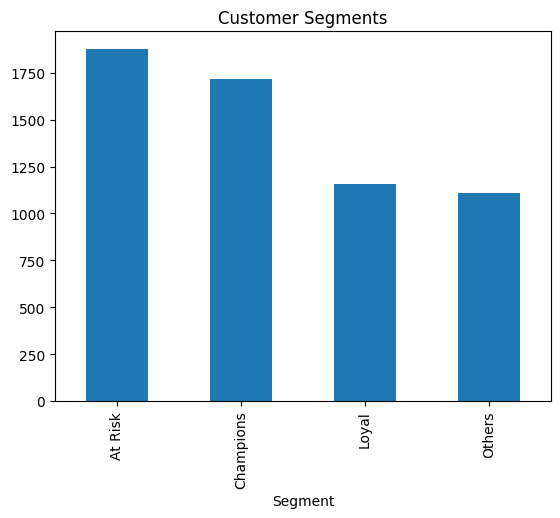

In [38]:
rfm["Segment"].value_counts().plot(kind="bar", title="Customer Segments")
plt.show()

In [39]:
rfm.to_csv("rfm_segments.csv")

In [40]:
actions = """
Champions:
1. Give exclusive discounts and early access to new products
2. Offer loyalty rewards and VIP programs
3. Upsell premium or high-margin products

Loyal:
1. Send personalized recommendations
2. Offer membership or points-based rewards
3. Encourage referrals with bonuses

At Risk:
1. Send win-back emails with special discounts
2. Offer limited-time offers to re-engage
3. Ask for feedback to understand churn reasons

Others:
1. Send onboarding and awareness campaigns
2. Offer small discounts to encourage repeat purchase
3. Show popular or trending products
"""

with open("segment_actions.txt", "w") as f:
    f.write(actions)

print("segment_actions.txt file created!")

segment_actions.txt file created!
